# Tabla de Contenidos

* [Especificaciones de tuplas, macros y zonas en modelos Cell-DEVS](#especificaciones-avanzadas-celldevs)
* [Modelo de Evacuación de Edificios](#evacuacion-edificios)
* [Ejemplo 1: evacuación sin humo, ni accidentes](#sin-humo-ni-accidentes)
* [Ejemplo 2: Evacuación con humo y sin accidentes](#con-humo-sin-accidentes)
* [Ejemplo 3: Evacuación con humo y accidentes](#con-humo-con-accidentes)

# Bibliotecas de Python 

En este notebook vamos a utilizar las siguientes bibliotecas de Python:
* pathlib
* os
* pandas
* scipy
* numpy
* matplotlib

Para instalarlas podemos correr la siguiente línea (si están usando un *venv* deben correrlo dentro del entorno virtual):

```
$ pip install pathlib sys matplotlib scipy numpy
```

# Inicialización

Definamos algunas variables de entorno que utilizaremos a lo largo de este notebook:

In [158]:
from pathlib import Path

SED_HOME = Path.home().joinpath('SED')

#Directorio base donde está instalado el siumulador
CDPP_DIR = SED_HOME.joinpath('CDPP_ExtendedStates-codename-Santi')

CDPP_SRC = CDPP_DIR.joinpath('src')
CDPP_EXAMPLES = CDPP_DIR.joinpath('examples')
CDPP_SCRIPTS = CDPP_DIR.joinpath('scripts')
BASE_BIN = CDPP_SRC.joinpath('bin')
CDPP_ATOMICS = CDPP_SRC.joinpath('cd++/atomics')

CDPP_EXAMPLES_CELL = CDPP_EXAMPLES.joinpath('cell-devs')
CDPP_BIN = BASE_BIN.joinpath('cd++')
DRAWLOG_BIN = BASE_BIN.joinpath('drawlog')

# URL del repositorio de ejemplos
URL = 'http://www.sce.carleton.ca/faculty/wainer/wbgraf/samples/'

<center></center>

# Bibliografía

* Presentaciones de la materia
* Libro: Wainer, G. (2009) _Discrete-Event Modeling and Simulation: A practitioners approach_ (Capítulo 3)
* Manual de usuario CD++

<a id='especificaciones-avanzadas-celldevs'></a>
# Especificaciones de tuplas, macros y zonas en modelos Cell-DEVS

En algunos modelos Cell-DEVS vamos a utilizar:
  * Valores de las celdas con tuplas
  * Zonas
  * Macros

## Tuplas

* Con la versión del simulador `CD++-codename-Santi` se incorporaron **tuplas** de $N$ elementos para utilizar tanto en los modelos DEVS como en los modelos Cell-DEVS.

* Para especificar el valor de una celda como una tupla utilizamos corchetes `[]`. 
  * Por ejemplo, para asignar el valor `[0,0]` a todas las celdas de la grilla usamos:

```
   initialvalue : [0,0,1,5]
```

  * Por otro lado, para asignar el valor un valor `[1,0]` a la celda con coordenadas $x=0$, $y=0$ y $z=0$ usamos:

```
   (0,0,0) = [1,0]
```

* Para referirnos a uno de los elementos de la tupla utilizamos el operador `!`. 
  * Por ejemplo, para preguntar si el primer elemento de la tupla que define el valor de la celda $(0,0,0)$ es mayor a $10$ usamos:

```
   ( 0, 0, 0)!0 > 10 
```
    
  * En el ejemplo anterior esto último devuelve _falso_.

## Macros

Las cláusulas #BeginMacro y #EndMacro permiten dar comienzo y fin a la definición de una **macro**:

```
#BeginMacro(nombreMacro)
...
...contenido de la macro...
...
#EndMacro
```

Veamos algunos ejemplos de definiciones con macros:

  * Dirección **Norte** en la capa 0:

```
  #BeginMacro(CELL_N)
    (0,1,0)
  #EndMacro
```

  * Dirección **Sur-Este** en la capa 2:

```
  #BeginMacro(CELL_SE_2)
    (1,-1,2)
  #EndMacro
```
  
* Las macros se definen en un archivo aparte que se incluye en el `.ma`. 
  * La cláusula `#include` permite incluir el contenido de un archivo. 
  * Su formato es: 

```
  #include(fileName) 
```

    donde `fileName` es el nombre del archivo que contiene la definición de las macros.

## Zonas

En Cell-DEVS podemos definir **zonas** de celdas para asignar un comportamiento alternativo para el conjunto de celdas comprendidas en ellas. 

El formato es: 

```
zone : transitionFunctionName { rango_1 [..rango_n ] }
```

Cada rango puede estar formado por:
  * celdas: $(x_1, x_2,\dots,x_n)$
  * grupos de celdas: $(x_1, x_2,\dots,x_n)..(y_1, y_2,\dots, y_n)$
  * una lista que combina una cantidad arbitraria de ambas (separando a cada elemento de la misma por un espacio en blanco): $(x_1, x_2,\dots,x_n)..(y_1, y_2,\dots, y_n)\;\;(z_1, z_2,\dots, z_n)$

Veamos un ejemplo de especificación de una zona:

```
zone : bache { (10,10)..(13,13) (1,3) }
```

En el momento de calcular el nuevo estado para una celda, si dicha celda pertenece a algún rango se usarán las reglas definidas para tal, y sino se utilizarán las _reglas generales_ definidas en la cláusula `LocalTransition`.

<a id='evacuacion-edificios'></a>
# Modelo de Evacuación de Edificios

* Este modelo, plantea la evacuación de un edificio, permitiendo modelar y simular el escape de personas ante una situación de emergencia. 

* Esto es algo de mucha aplicación práctica para el caso de incendios, sismos, etc. 

* Con este modelo se pueden evaluar cómo distintos diseños de los planos del edificio (distribución del piso, habitaciones, escaleras, etc) afecta el tiempo de evacuación, permitiendo simular edificios de varios pisos. 

* En este modelo utilizaremos varios niveles y en cada nivel vamos a representar distintas dinámicas como las vistas en las clases pasadas:
  * Movimiento de personas
  * Difusión del humo

Descargar el archivo `CellDEVS-EvacuacionEdificio.zip` del campus de la materia en la carpeta `examples/cell-devs/` y descomprimirlo.

## Descripción del modelo (modelo conceptual)

El comportamiento del modelo podemos dividirlo en dos partes:

1. **Determinación del camino de evacuación hacia la salida desde cualquier celda.**
    * Esta parte del modelo permite determinar para cada piso de un edificio el camino de salida desde cualquier celda. 
    * El camino de evacuación hacia la salida se determina arrancando por la salida y va determinando qué movimiento debe realizar la persona en la celda para llegar a la salida (onda expansiva desde las salidas del edificio).
    * Veamos un ejemplo de la primer iteración en un piso donde las salidas están marcadas con **S**:

<center></center>

      La iteración siguiente examina una celda más adelante desde la salida y determina qué dirección debe tomar esa nueva celda para llegar a la salida.

<center></center>

  * Este procedimiento se repite hasta que todas las direcciones hacia las salidas hayan sido determinadas en todas las celdas del edificio. 
  * El cálculo de estas direcciones (o su determinación) se ejecuta de manera instantánea (no consumen tiempo de simulación).

2. **Determinación de las celdas ocupadas por personas**
3. **Evacuación: movimiento de las personas en el edificio.**
   * En esta parte del modelo, se modela el comportamiento de las personas y su capacidad de moverse bajando de un piso a otro hasta la salida más próxima. 
     * Las personas se mueven en tiempo discreto de un paso por vez. 
     * En caso que la celda a la que tengan que desplazarse se encuentre ocupada, esperará su turno hasta que se pueda mover.

## Codificación de los estados

La codificación de estados de cada celda se define por una **tupla** con dos valores: `[edificio/movimiento, persona]` 

1. La primera componente de la tupla describe cuestiones edilicias y la dirección calculada hacia la salida:

| Valor | Edificio / Movimiento |
|:-|:-|
| 1| Pared |
| 2| Salida |
| 3| El camino más cercano hacia la salida es hacia abajo (+x) |
| 5| El camino más cercano hacia la salida es hacia la derecha (+y) |
| 7| El camino más cercano hacia la salida es hacia arriba (-x) |
| 9| El camino más cercano hacia la salida es hacia la izquierda (-y) |
|11| Escalera hacia abajo |
|13| Escalera desde arriba |

2. La segunda componente de la tupla describe si hay una persona en la celda o no:

|Valor|Persona|
|:-|:-|
|0| Libre|
|1| <span style='background:lightblue' > Ocupado</span>|

## Simulador y modelo por separado

### Modelo: modelo acoplado y componentes

Este modelo no tiene puertos de entrada ni puertos de salida y consiste del modelo acoplado Top que contiene:
* Edificio de 3 niveles con personas, donde se realiza la evacuación: modelo _cell-DEVS_

<center></center>

<a id='sin-humo-ni-acientes'></a>
# Ejemplo 1: Evacuación sin Humo ni accidentes

## Modelo _cell-DEVS_ de la evacuación

* Este modelo consiste de una grilla de celdas que representan áreas pequeñas de superficie.
* El valor de cada celda es una tupla que indica: `[edifico/movimiento, persona]`
* El modelo cell-DEVS tiene: 
  * Tamaño: $10 \times 10 \times 3$
  * Bordes: _nowrapped_
  * Retardo: _transporte_

### Niveles

Hasta ahora vimos modelos de autómatas celulares con $2$ dimensiones $x$ e $y$. 

En el modelo que desarrollaremos a continuación agregaremos una coordenada adicional $z$ para representar el piso del edificio (nivel).

Para agregar más niveles agregamos más dimensiones a las celdas de la grilla:

```
dim : (10,10,3)
```

### Vecindario

* Se considera que las personas se pueden mover en 4 direcciones en un mismo plano (grilla de 3x3) y se contemplan los movimientos de subir y bajar las escaleras. 
* Por lo tanto a la grilla de 3x3 se le agregan 2 celdas más que permitan describir el movimiento de cambiarse de piso: $(0,0,1)$ y $(0,0,-1)$. 
* El vecindario también incorpora 2 celdas adicionales para evitar colisiones, i.e. dos personas que se muevan a la misma celda: $(-2,0,0)$ y $(0,2,0)$. 
* A pesar de que dispone de 4 movimientos posibles en el mismo plano, utiliza únicamente 2 celdas anti-colisiones para dar prioridad a esos movimientos.

```
neighbors :                ship(-2,0,0)
neighbors : ship(-1,-1, 0) ship(-1,0,0) ship(-1,1,0)
neighbors : ship( 0,-1, 0) ship( 0,0,0) ship( 0,1,0) ship(0,2,0)
neighbors : ship( 1,-1, 0) ship( 1,0,0) ship( 1,1,0)
neighbors : ship( 0, 0,-1) ship( 0,0,1)
```

<center></center>

### Valores iniciales

Todas las celdas inician con valor $[0,0]$: 
```
initialvalue : [0,0]
```

Sin embargo, algunas celdas reciben valores particulares que indican características edilicias: 
* $[1,0]$: Pared
* $[2,0]$: Salida
* $[11,0]$: Escalera hacia abajo
* $[13,0]$: Escalera desde arriba

Estos valores se asignan mediante el archivo `building1_tupla.val`:

```
initialCellsValue : building1_tupla.val
```

A continuación veamos el contenido de este archivo:

In [160]:
%%bash -s "$CDPP_EXAMPLES_CELL"

cd $1/CellDEVS-EvacuacionEdificio/code/

head building1_tupla.val  

(0,0,0) = [1,0]
(0,1,0) = [1,0]
(0,2,0) = [13,0]
(0,3,0) = [13,0]
(0,4,0) = [13,0]
(0,5,0) = [13,0]
(0,6,0) = [13,0]
(0,7,0) = [1,0]
(0,8,0) = [1,0]
(0,9,0) = [1,0]


Si tomamos los valores iniciales del nivel $z=0$ (Planta baja) correspondiente a la planta baja del edificio:

<center></center>

### Reglas

A continuación vamos a agrupar las reglas en:

  1. Reglas para inicializar direcciones de evacuación e incorporar de personas
  2. Reglas de movimiento de personas
  3. Reglas de escaleras

### Reglas para inicializar direcciones de evacuación e incorporar personas

* Al inicio de la simulación, ninguna celda tiene definida la **dirección de evacuación**, excepto las que corresponden a: pared, salida o escaleras.
* Las primeras cuatro reglas se utilizan para definir las **direcciones de evacuación**.
* Estas reglas se ejecutan al inicio de la simulación y pueden tener uno de cuatro resultados dependiendo de la posición relativa de la celda en relación a su ubicación en el edificio (cercanı́a con salidas y/o escaleras):

  * $3$: El camino más cercano hacia la salida es hacia abajo (+x)
  * $5$: El camino más cercano hacia la salida es hacia la derecha (+y)
  * $7$: El camino más cercano hacia la salida es hacia arriba (-x)
  * $9$: El camino más cercano hacia la salida es hacia la izquierda (-y)


* Mediante estas reglas también se agregan las personas aleatoriamente al modelo. 

  * Este modelo contempla una densidad de personas del 50% del espacio disponible
  * Se utiliza la función `randInt(1)` para determinar si hay una persona o no en la celda.


* Notar que las reglas que siguen se irán propagando desde aquellas que estén más cerca de una salida o escalera hacia las demás en tiempo $0$ ($retardo=0$).
* Podemos notar también que de acuerdo a cómo están ordenadas las reglas se privilegia la dirección de evauación **hacia abajo**, luego **hacia la derecha**, luego **hacia arriba** y finalmente **hacia la izquierda**.
* Este conjunto de reglas dejarán de ejecutarse cuando todas las celdas tenga un valor distinto de $[0,0]$.

* **Regla 1**

  * Si la celda actual no está inicializada ($(0,0,0) = [0,0]$) y la celda que está **abajo (+x)** tiene definida una dirección de evacuación ($( 1, 0, 0)!0 > 1  and ( 1, 0, 0)!0 < 10$) entonces la dirección hacia la salida más cercana para la celda actual es **hacia abajo (+x)**: $3 \,\downarrow$.
  * Se define si hay una persona en la celda actual con una variable aleatoria uniforme entre $0$ y $1$: `randInt(1)`

```
   rule : {[3,randInt(1)]} 0 { (0,0,0) = [0,0] and ( 1, 0, 0)!0 > 1  and ( 1, 0, 0)!0 < 10}
```

* **Regla 2**

  * Si la celda actual no está inicializada ($(0,0,0) = [0,0]$) y la celda que está hacia la **derecha (+y)** tiene definida una dirección de evacuación ($( 0, 1, 0)!0 > 1  and ( 0, 1, 0)!0 < 10$) entonces la dirección hacia la salida más cercana para la celda actual es **hacia la derecha (+y)**: $5 \, \rightarrow$.

```
   rule : {[5,randInt(1)]} 0 { (0,0,0) = [0,0] and ( 0, 1, 0)!0 > 1  and ( 0, 1, 0)!0 < 10}
```

* **Regla 3**

  * Si la celda actual no está inicializada ($(0,0,0) = [0,0]$) y la celda que está hacia **arriba (-x)** tiene definida una dirección de evacuación ($( -1, 0, 0)!0 > 1  and ( -1, 0, 0)!0 < 10$) entonces la dirección hacia la salida más cercana para la celda actual es **hacia arriba (-x)**: $7 \, \uparrow$.
  
```
   rule : {[7,randInt(1)]} 0 { (0,0,0) = [0,0] and (-1, 0, 0)!0 > 1  and (-1, 0, 0)!0 < 10} 
```

* **Regla 4**

  * Si la celda actual no está inicializada ($(0,0,0) = [0,0]$) y la celda que está hacia la **izquierda (-y)** tiene definida una dirección de evacuación ($( 0, -1, 0)!0 > 1  and ( 0, -1, 0)!0 < 10$) entonces la dirección hacia la salida más cercana para la celda actual es **hacia la izquierda (-y)**: $9 \,\leftarrow$.

```
   rule : {[9,randInt(1)]} 0 { (0,0,0) = [0,0] and ( 0,-1, 0)!0 > 1  and ( 0,-1, 0)!0 < 10}
```

El siguiente conjunto de reglas se utilizan en los pisos superiores en donde el camino hacia la salida implica un descenso mediante escaleras.

* **Regla 5**

  * Si la celda actual no está inicializada ($(0,0,0) = [0,0]$) y la celda que está hacia **abajo (+x)** es una escalera hacia abajo ($( 1, 0, 0)!0 > 10  and ( 1, 0, 0)!0 < 13$) entonces la dirección hacia la salida más cercana para la celda actual es **hacia abajo (+x)**: $3 \,\downarrow$.

```
   rule : {[3,randInt(1)]} 0 { (0,0,0) = [0,0] and ( 1, 0, 0)!0 > 10 and ( 1, 0, 0)!0 < 13}
```

* **Regla 6**

  * Si la celda actual no está inicializada ($(0,0,0) = [0,0]$) y la celda que está hacia la **derecha (+y)** es una escalera hacia abajo ($( 0, 1, 0)!0 > 10  and ( 0, 1, 0)!0 < 13$) entonces la dirección hacia la salida más cercana para la celda actual es **hacia la derecha (+y)**: $5 \,\rightarrow$.

```
   rule : {[5,randInt(1)]} 0 { (0,0,0) = [0,0] and ( 0, 1, 0)!0 > 10 and ( 0, 1, 0)!0 < 13}
```

* **Regla 7**

  * Si la celda actual no está inicializada ($(0,0,0) = [0,0]$) y la celda que está hacia **arriba (-x)** es una escalera hacia abajo ($( -1, 0, 0)!0 > 10  and ( -1, 0, 0)!0 < 13$) entonces la dirección hacia la salida más cercana para la celda actual es **hacia arriba (-x)**: $7 \,\uparrow$.

```
   rule : {[7,randInt(1)]} 0 { (0,0,0) = [0,0] and (-1, 0, 0)!0 > 10 and (-1, 0, 0)!0 < 13} 
```


* **Regla 8**

  * Si la celda actual no está inicializada ($(0,0,0) = [0,0]$) y la celda que está hacia la **izquierda (-y)** es una escalera hacia abajo ($( 0, -1, 0)!0 > 10  and ( 0, 1, 0)!0 < 13$) entonces la dirección hacia la salida más cercana para la celda actual es **hacia la izquierda (-y)**: $9 \,\leftarrow$.


```
   rule : {[9,randInt(1)]} 0 { (0,0,0) = [0,0] and ( 0,-1, 0)!0 > 10 and ( 0,-1, 0)!0 < 13}
```

### Reglas de movimiento de personas

* Los movimientos de las personas en el edificio se realizan utilizando tres conjuntos de cuatro reglas cada uno.
* Recordemos en el ejemplo de **Personas** que el movimiento de una persona de una celda a una vecina se hacía en dos pasos:
  * Primero la persona revisa si la celda vecina está vacía y si lo está entonces abandona la celda actual.
  * Luego la vecina revisa si ella está vacía y si su vecina está ocupada y en ese caso recibe a la persona.
  
  
#### Reglas para mover personas a una celda vacía

El conjunto de reglas que sigue es utilizado para **mover personas a una celda vacı́a**.

* **Regla 9**

  * Si la celda actual está vacía y su dirección de evacuación **hacia abajo (+x)** ($(0,0,0) = [3,0]$) y:
  
    * La celda vecina a la derecha (+y) está ocupada y su dirección de evacuación es hacia la izquierda ($(0,1,0) = [9,1]$), o
    * La celda vecina arriba (-x) está ocupada y su dirección de evacuación es hacia abajo ($(-1,0,0) = [3, 1]$), o
    * La celda vecina a la izquierda (-y) está ocupada y su dirección de evacuación es hacia la derecha ($( 0,-1,0) = [5,1]$), o
    * Una de sus vecinas está ocupada y su dirección es escalera desde arriba:
      * La celda vecina arriba (-x) está ocupada y su dirección es escalera desde arriba ($(-1,0,0) = [13, 1]$), o
      * La celda vecina abajo (+x) está ocupada y su dirección es escalera desde arriba ($(1,0,0) = [13, 1]$), o
      * La celda vecina a la derecha (+y) está ocupada y su dirección es escalera desde arriba ($(0,1,0) = [13,1]$), o
      * La celda vecina a la izquierda (-y) está ocupada y su dirección es escalera desde arriba ($( 0,-1,0) = [13,1]$)
    
  * Entonces recibe a una persona y su estado pasa de: $[3,0] \to [3,1]$

```
   rule : {[3,1] } 100 { (0,0,0) = [3,0] and ( (0,1,0) = [9,1] or (-1,0,0) = [3, 1] or ( 0,-1,0) = [5,1] or (-1,0,0) = [13,1] or (1,0,0) = [13,1] or (0,1,0) = [13,1] or (0,-1,0) = [13,1] )}
```

* **Regla 10**

  * Si la celda actual está vacía y su dirección de evacuación **hacia la derecha (+y)** ($(0,0,0) = [5,0]$) y:
  
    * La celda vecina abajo (+x) está ocupada y su dirección de evacuación es hacia arriba ($(1,0,0) = [7, 1]$), o
    * La celda vecina arriba (-x) está ocupada y su dirección de evacuación es hacia abajo ($(-1,0,0) = [3, 1]$), o
    * La celda vecina a la izquierda (-y) está ocupada y su dirección de evacuación es hacia la derecha ($( 0,-1,0) = [5,1]$), o
    * Una de sus vecinas está ocupada y su dirección es escalera desde arriba:
      * La celda vecina arriba (-x) está ocupada y su dirección es escalera desde arriba ($(-1,0,0) = [13, 1]$), o
      * La celda vecina abajo (+x) está ocupada y su dirección es escalera desde arriba ($(1,0,0) = [13, 1]$), o
      * La celda vecina a la derecha (+y) está ocupada y su dirección es escalera desde arriba ($(0,1,0) = [13,1]$), o
      * La celda vecina a la izquierda (-y) está ocupada y su dirección es escalera desde arriba ($( 0,-1,0) = [13,1]$)
    
  * Entonces recibe a una persona y su estado pasa de: $[5,0] \to [5,1]$
  
```
   rule : {[5,1] } 100 { (0,0,0) = [5,0] and ( (1,0,0) = [7, 1] or (-1,0,0) = [3, 1] or ( 0,-1,0) = [5,1] or (-1,0,0) = [13,1] or (1,0,0) = [13,1] or (0,1,0) = [13,1] or (0,-1,0) = [13,1] )}
```

* **Regla 11**

  * Si la celda actual está vacía y su dirección de evacuación **hacia arriba (-x)** ($(0,0,0) = [7,0]$) y:
    
    * La celda vecina abajo (+x) está ocupada y su dirección de evacuación es hacia arriba ($(1,0,0) = [7, 1]$), o
    * La celda vecina a la derecha (+y) está ocupada y su dirección de evacuación es hacia la izquierda ($(1,0,0) = [9, 1]$), o
    * La celda vecina a la izquierda (-y) está ocupada y su dirección de evacuación es hacia la derecha ($( 0,-1,0) = [5,1]$), o
    * Una de sus vecinas está ocupada y su dirección es escalera desde arriba:
      * La celda vecina arriba (-x) está ocupada y su dirección es escalera desde arriba ($(-1,0,0) = [13, 1]$), o
      * La celda vecina abajo (+x) está ocupada y su dirección es escalera desde arriba ($(1,0,0) = [13, 1]$), o
      * La celda vecina a la derecha (+y) está ocupada y su dirección es escalera desde arriba ($(0,1,0) = [13,1]$), o
      * La celda vecina a la izquierda (-y) está ocupada y su dirección es escalera desde arriba ($( 0,-1,0) = [13,1]$)
    
  * Entonces recibe a una persona y su estado pasa de: $[7,0] \to [7,1]$

```
   rule : {[7,1] } 100 { (0,0,0) = [7,0] and ( (1,0,0) = [7, 1] or ( 0,1,0) = [9,1] or ( 0,-1,0) = [5,1] or (-1,0,0) = [13,1] or (1,0,0) = [13,1] or (0,1,0) = [13,1] or (0,-1,0) = [13,1] )}
```

* **Regla 12**

  * Si la celda actual está vacía y su dirección de evacuación **hacia la izquierda (-y)** ($(0,0,0) = [9,0]$) y:
  
    * La celda vecina abajo (+x) está ocupada y su dirección de evacuación es hacia arriba ($(1,0,0) = [7, 1]$), o
    * La celda vecina a la derecha (+y) está ocupada y su dirección de evacuación es a la izquierda ($(0,1,0) = [9, 1]$), o
    * La celda vecina a arriba (-x) está ocupada y su dirección de evacuación es hacia abajo ($(-1,0,0) = [3, 1]$), o
    * Una de sus vecinas está ocupada y su dirección es escalera desde arriba:
      * La celda vecina arriba (-x) está ocupada y su dirección es escalera desde arriba ($(-1,0,0) = [13, 1]$), o
      * La celda vecina abajo (+x) está ocupada y su dirección es escalera desde arriba ($(1,0,0) = [13, 1]$), o
      * La celda vecina a la derecha (+y) está ocupada y su dirección es escalera desde arriba ($(0,1,0) = [13,1]$), o
      * La celda vecina a la izquierda (-y) está ocupada y su dirección es escalera desde arriba ($( 0,-1,0) = [13,1]$)
    
  * Entonces recibe a una persona y su estado pasa de: $[9,0] \to [9,1]$

```
   rule : {[9,1]} 100 { (0,0,0) = [9,0] and ( (1,0,0) = [7, 1] or ( 0,1,0) = [9,1] or (-1, 0,0) = [3,1] or (-1,0,0) = [13,1] or (1,0,0) = [13,1] or (0,1,0) = [13,1] or (0,-1,0) = [13,1] )}
```

#### Reglas para borrar personas de una celda

El conjunto de reglas que sigue se utiliza para **borrar a las personas de la celda** una vez que se han desplazado de ella.

* **Regla 13**

  * Si la celda actual está ocupada y su dirección de evacuación es **hacia abajo (+x)** ($(0,0,0) = [3, 1]$) y la celda de abajo está vacía ($(1,0,0)!1 = 0$) entonces abandona la celda.
  
```
   rule : {[3,0]}  100 { (0,0,0) = [3, 1] and ((1,0,0)!1 = 0) }
```

* **Regla 14**

  * Si la celda actual está ocupada y su dirección de evacuación es **hacia la izquierda (-y)** ($(0,0,0) = [9, 1]$) y:
    * la celda a la izquierda está vacía ($(0,-1,0)!1 = 0$), y 
    * la celda ubicada arriba a la izquierda no tiene dirección de evacuación hacia abajo y está ocupada ($(-1,-1,0) != [3,1]$) 
  * Entonces abandona la celda.
  
```
   rule : {[9,0]}  100 { (0,0,0) = [9,1] and (( 0,-1,0)!1 = 0) and (-1,-1,0) != [3,1] }
```

* **Regla 15**

  * Si la celda actual está ocupada y su dirección de evacuación es **hacia arriba (-x)** ($(0,0,0) = [7, 1]$) y:
    * la celda de arriba está vacía ($(-1,0,0)!1 = 0$), y 
    * la celda ubicada arriba de ella no tiene dirección de evacuación hacia abajo y está ocupada ($(-2,0,0) != [3,1]$), y 
    * la celda ubicada arriba a la derecha no tiene dirección de evacuación hacia la izquierda y está ocupada ($(-1,1,0) != [9,1]$) 
  * Entonces abandona la celda.

```
rule : {[7,0]}  100 { (0,0,0) = [7 ,1] and ((-1, 0,0)!1 = 0) and (-2, 0,0) != [3,1] and (-1,1,0) != [9,1] }     
```

* **Regla 16**

  * Si la celda actual está ocupada y su dirección de evacuación es **hacia la derecha (+y)** ($(0,0,0) = [5, 1]$) y:
    * la celda de la derecha está vacía ($(0,1,0)!1 = 0$), y 
    * la celda ubicada arriba de ella no tiene dirección de evacuación hacia abajo y está ocupada ($(-1,1,0) != [3,1]$), y 
    * la celda ubicada a la derecha de ella no tiene dirección de evacuación hacia la izquierda y está ocupada ($(0,2,0) != [9,1]$), y 
    * la celda ubicada debajo de ella no tiene dirección de evacuación hacia arriba y está ocupada ($(1,1,0) != [7,1]$)
  * Entonces abandona la celda.

```
rule : {[5,0]}  100 { (0,0,0) = [5 ,1] and (( 0, 1,0)!1 = 0) and (-1, 1,0) != [3,1] and (0, 2,0) != [9,1] and (1,1,0) != [7,1] }
```

### Reglas de escaleras

  * Existen dos tipos de celdas de escalera:
  
    * $11$: Escalera **hacia abajo**
    * $13$: Escalera **desde arriba**
    


* **Regla 17**

  * Si la celda actual es una escalera hacia abajo y está vacía ($(0,0,0) = [11,0]$) y:
    * La celda ubicada arriba (-x) tiene dirección de evacuación hacia abajo y está ocupada ($(-1,0,0) = [3,1]$), o
    * la celda ubicada a la izquierda (-y) tiene dirección de evacuación hacia la derecha y está ocupada ($(0,-1,0) = [5,1]$), o
    * la celda ubicada abajo (+x) tiene dirección de evacuación hacia arriba y está ocupada ($(1,0,0) = [7,1]$), o
    * la celda ubicada a la derecha (+y) tiene dirección de evacuación hacia la izquierda y está ocupada ($(0,1,0) = [9,1]$)
  * Entonces recibe a esa persona y su estado pasa de: $[11,0] \to [11,1]$ 

```
   rule : {[11,1]} 100 { (0,0,0) = [11,0] and ((-1,0,0) = [3,1] or (0,-1,0) = [5,1] or (1,0,0) = [7,1] or (0,1,0) = [9,1] ) } 
```

* **Regla 18**

  * Si la celda actual es una escalera hacia abajo y está ocupada ($(0,0,0) = [11,1]$) y:
    * La celda ubicada en el piso inferior (-z) es una escalea desde arriba y está vacía ($(0,0,-1) = [13,0]$)
  * Entonces abandona la celda (para descender al piso inferior)

```
   rule : {[11,0]} 100 { (0,0,0) = [11,1] and (0,0,-1) = [13,0] } 
```

* **Regla 19**

  * Esta regla complementa a la anterior.
  * Si la celda actual es una escalera desde arriba y está vacía ($(0,0,0) = [13,0]$) y:
    * La celda ubicada en el piso superior (+z) es una escalea hacia abajo y está ocupada ($(0,0,1) = [11,1]$)
  * Entonces recibe a esa persona

```
   rule : {[13,1]} 100 { (0,0,0) = [13,0] and (0,0,1) = [11,1] }
```


* **Regla 20**

  * Si la celda actual es una escalera desde arriba y está ocupada ($(0,0,0) = [13,1]$) y alguna de sus vecinas en +x, -x, +y o -y tienen dirección de evacuación hacia arriba, abajo, izquierda o derecha 
    * La vecina ubicada abajo (+x), arriba (-x), a derecha (+y) o izquierda (-y) tiene:
      * dirección de evacuación hacia abajo y está vacía ($(\ast,\vartriangle,0) = [3,0]$), o
      * dirección de evacuación hacia la derecha y está vacía ($(\ast,\vartriangle,0) = [5,0]$), o
      * dirección de evacuación hacia arriba y está vacía ($(\ast,\vartriangle,0) = [7,0]$), o
      * dirección de evacuación hacia la izquierda y está vacía ($(\ast,\vartriangle,0) = [9,0]$)
  * Entonces abandona la celda (para moverse a alguna de las vecinas) 

```
   rule : {[13,0]} 100 { (0,0,0) = [13,1] and ( (1,0,0) = [3,0] or (1,0,0) = [5,0] or (1,0,0) = [7,0] or (1,0,0) = [9,0] or (-1,0,0) = [3,0] or (-1,0,0) = [5,0] or (-1,0,0) = [7,0] or (-1,0,0) = [9,0] or (0,1,0) = [3,0] or (0,1,0) = [5,0] or (0,1,0) = [7,0] or (0,1,0) = [9,0] or (0,-1,0) = [3,0] or (0,-1,0) = [5,0] or (0,-1,0) = [7,0] or (0,-1,0) = [9,0]) }
```

* **Regla _default_**

  * Si no se ejecuto ninguna  de las reglas anteriores entonces el valor de la celda actual permanece sin cambios.
  
```
   rule: {(0,0,0)} 100 {t}
```

Con la ayuda de un visualizador de texto podemos ver el contenido del archivo `building1_tupla.ma`:

In [161]:
%%bash -s "$CDPP_EXAMPLES_CELL"

cd $1/CellDEVS-EvacuacionEdificio/code/

cat building1_tupla.ma

[top]
components : evacuation

[evacuation]
type : cell
dim : (10,10,3)
delay : transport
defaultDelayTime : 20
border : nowrapped 
neighbors : ship(-2,0,0)
neighbors : ship(-1,-1,0) ship(-1,0,0) ship(-1,1,0)
neighbors : ship(0,-1,0)  ship(0,0,0) ship(0,1,0) ship(0,2,0)
neighbors : ship(1,-1,0)  ship(1,0,0) ship(1,1,0)
neighbors : ship(0,0,-1)  ship(0,0,1)

initialvalue : [0,0]
initialCellsValue : building1_tupla.val

localtransition : evacuation-rule
[evacuation-rule]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% Pathway Rules
% [building, people]
% Where:
%   people = 0 (empty) - 1 (occupied)
%   building = 3 (down) - 5 (right) - 7 (up) - 9 (left)
%              1  wall
%              2  exit
%              11 Top stairs
%              13 Bottom stairs
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
rule : {[3,randInt(1)]} 0 { (0,0,0) = [0,0] and ( 1, 0, 0)!0 > 1  and ( 1, 0, 0)!0 < 10}
rule : {[5,randInt(1)]} 0 { (0,0,0) = [0,0] and ( 0, 1, 0)!0 > 1  and ( 0, 1,

## Simulación del modelo con CD++

Simulemos $2~\text{s}$ de la evacuación:

In [177]:
%%bash -s "$CDPP_EXAMPLES_CELL"

cd $1/CellDEVS-EvacuacionEdificio/code

# Corre el modelo
../../../../src/bin/cd++ -m building1_tupla.ma \
                         -l ./logs/building1_tupla.log \
                         -o ./logs/building1_tupla.out \
                         -t 00:00:02:000

PCD++: A Tool to Implement n-Dimensional Cell-DEVS models
Version 3.0 - March 2003
Troccoli A., Rodriguez D., Wainer G., Barylko A., Beyoglonian J., Lopez A.
-----------------------------------------------------------------------------
PCD++ Extended States: An extended and improved version of CD++ for Cell-DEVS
Version 4.1.2 - December 2018
Santi L., Castro, R., Pimás, J.
-----------------------------------------------------------------------------
Discrete Event Simulation Lab
Departamento de Computación
Facultad de Ciencias Exactas y Naturales
Universidad de Buenos Aires, Argentina
-----------------------------------------------------------------------------
Compiled for standalone simulation


Loading models from building1_tupla.ma
Loading events from 
Running parallel simulation. Reading models partition from 
Model partition details output to: /dev/null*
Message log: ./logs/building1_tupla.log
Output to: ./logs/building1_tupla.out
Tolerance set to: 1e-08
Configuration to show rea

## Análisis de los resultados

En este caso no podremos utilizar el visualizador Web Viewer ni el Drawlog porque no manejan tuplas.

Se desarrolló un visualizador _custom_ para este modelo: `helperDraw`

### Visualización _helperDraw_

Se armo un script para facilitar la visualización de los logs donde es posible detallar que instante de tiempo de la simulación se desea simular.

Ejemplo: 

```
     ./helperDraw.py -x 10 -y 10 -z 3 -out png -plot 1 -adv 1 -time 00:00:00:500:0 -log ./logs/building1.log01
```  

donde: 

* `x` :   size x del plano
* `y` :   size y del plano
* `z` :   cantidad de pisos del edificio
* `out`:  png | pdf. Genera un archivo de salida en la carpeta img/
* `plot`: 1 | 0, si queres que salga la pantalla de matplotlib
* `adv`:  1 para simulador avanzado, 0 para parsear logs generados por el sim de la VM
* `time`: El tiempo que querés visualizar
* `log`:  El archivo de log que generó el simulador cd++

Veamos una imagen de los instantes inicial, final y algunos valores intermedios de la simulación:

<font color=red>NOTA: en la primera línea de `helperDraw` apuntar a la ruta de las biliotecas de python dentro del entorno virtual: `#!/path_al_venv/usr/bin/python`</font>

In [198]:
%%bash -s "$CDPP_EXAMPLES_CELL"

cd $1/CellDEVS-EvacuacionEdificio/code

# instante inicial
./helperDraw.py -x 10 -y 10 -z 3 -out png -plot 0 -adv 1 -time 00:00:00:000:0 -log ./logs/building1_tupla.log01

#
./helperDraw.py -x 10 -y 10 -z 3 -out png -plot 0 -adv 1 -time 00:00:00:500:0 -log ./logs/building1_tupla.log01

#
./helperDraw.py -x 10 -y 10 -z 3 -out png -plot 0 -adv 1 -time 00:00:01:000:0 -log ./logs/building1_tupla.log01

#
./helperDraw.py -x 10 -y 10 -z 3 -out png -plot 0 -adv 1 -time 00:00:01:500:0 -log ./logs/building1_tupla.log01

#instante final
./helperDraw.py -x 10 -y 10 -z 3 -out png -plot 0 -adv 1 -time 00:00:02:000:0 -log ./logs/building1_tupla.log01

El resultado se almacena en la carpeta `img/`:

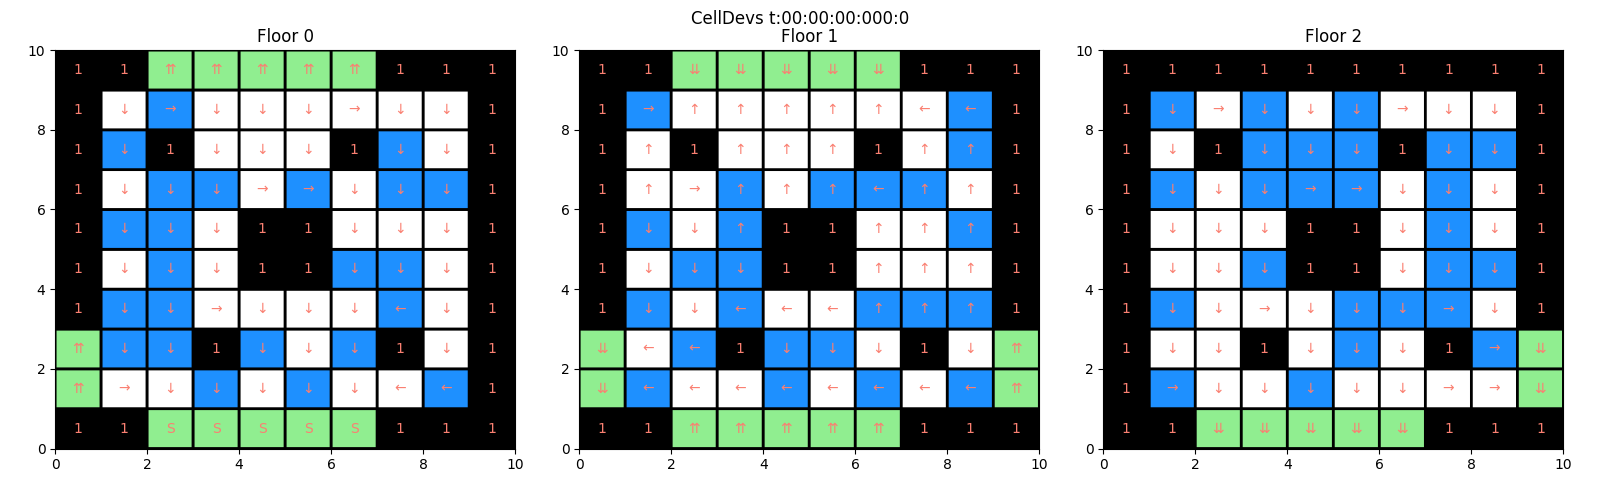

In [179]:
from IPython.display import Image
from IPython.core.display import HTML

PATH = str(CDPP_EXAMPLES_CELL)+'/CellDEVS-EvacuacionEdificio/code/img/'
Image(filename = PATH + "building1-tupla-log01-00-00-00-000-0.png", width=2000, height=500)

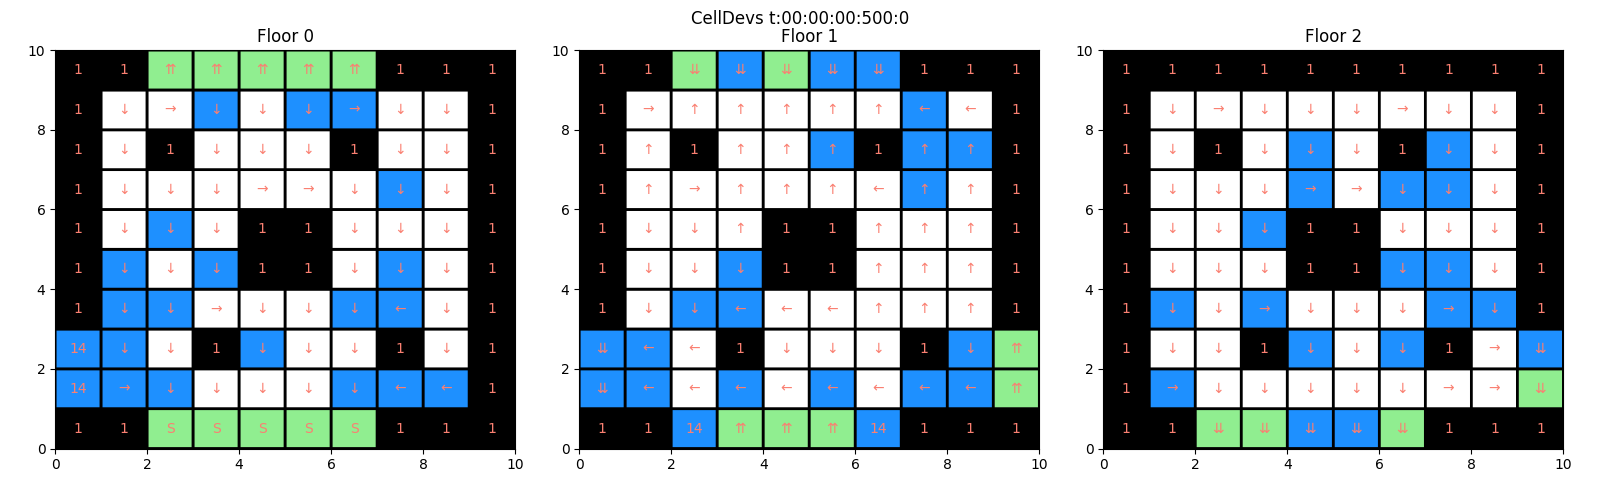

In [173]:
from IPython.display import Image
from IPython.core.display import HTML

PATH = str(CDPP_EXAMPLES_CELL)+'/CellDEVS-EvacuacionEdificio/code/img/'
Image(filename = PATH + "building1-tupla-log01-00-00-00-500-0.png", width=2000, height=500)

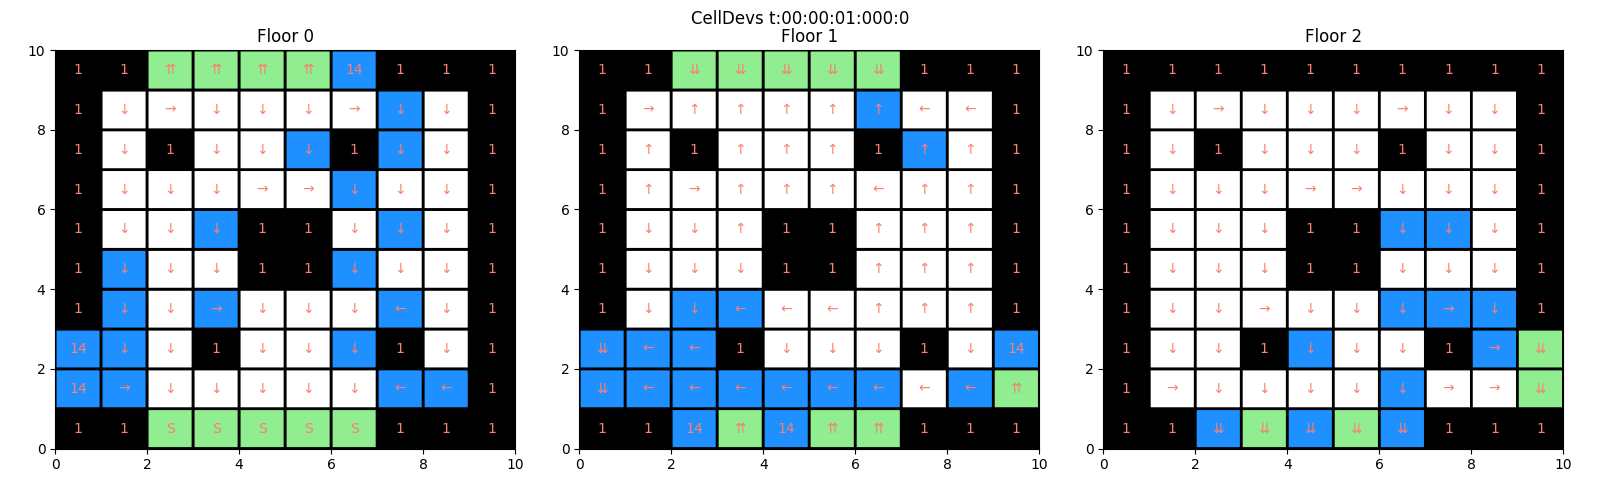

In [174]:
from IPython.display import Image
from IPython.core.display import HTML

PATH = str(CDPP_EXAMPLES_CELL)+'/CellDEVS-EvacuacionEdificio/code/img/'
Image(filename = PATH + "building1-tupla-log01-00-00-01-000-0.png", width=2000, height=500)

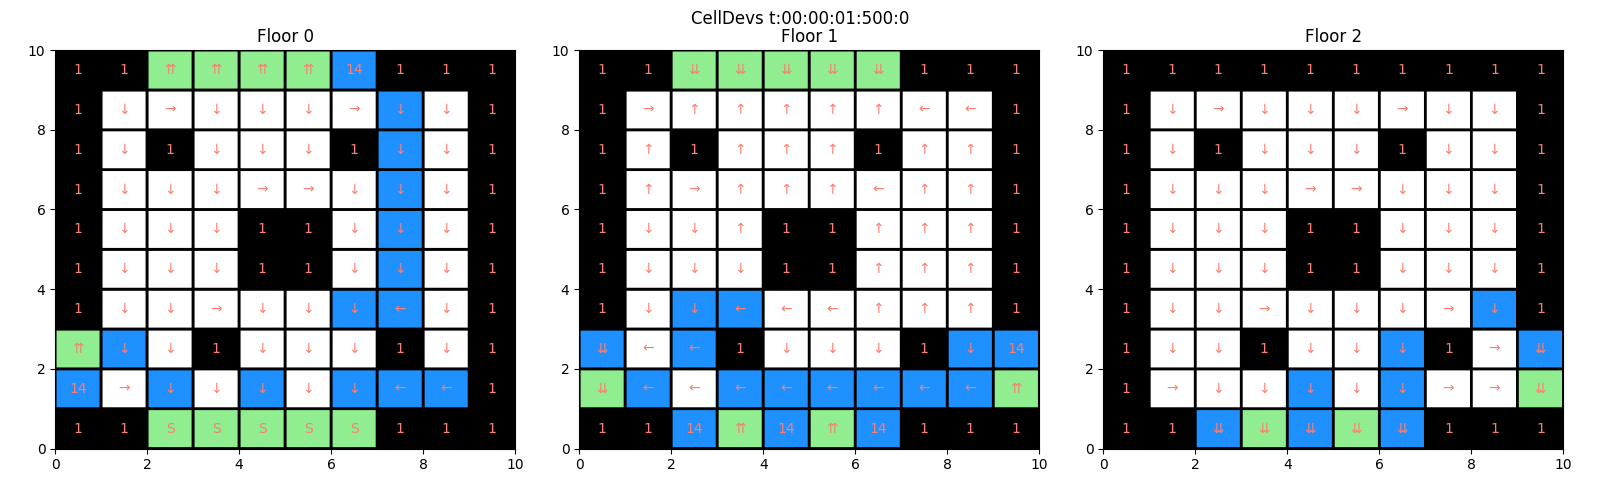

In [175]:
from IPython.display import Image
from IPython.core.display import HTML

PATH = str(CDPP_EXAMPLES_CELL)+'/CellDEVS-EvacuacionEdificio/code/img/'
Image(filename = PATH + "building1-tupla-log01-00-00-01-500-0.png", width=2000, height=500)

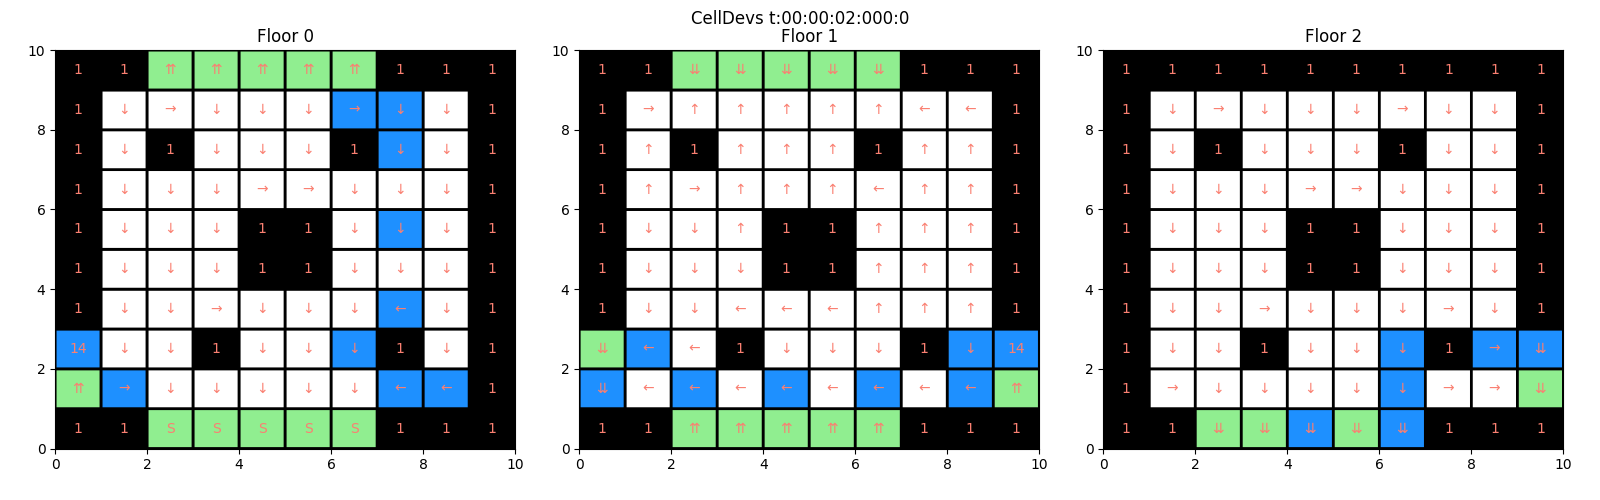

In [176]:
from IPython.display import Image
from IPython.core.display import HTML

PATH = str(CDPP_EXAMPLES_CELL)+'/CellDEVS-EvacuacionEdificio/code/img/'
Image(filename = PATH + "building1-tupla-log01-00-00-02-000-0.png", width=2000, height=500)

<a id='con-humo-sin-accidentes'></a>
# Ejemplo 2: Evacuación con humo y sin accidentes

* Se agrega la dinámica del humo, que ocurre independientemente del movimiento de personas.
* Consideraremos que el humo se transmite mediante un proceso difusivo. 
  * Para las celdas comunes, la celda toma como valor el promedio de las celdas vecinas (en un mismo piso) en un vecindario de Moore. 
  * Para las escaleras se agrega además el piso de arriba (o abajo, según corresponda) para tener difusión a través de los distintos pisos.

## Modelo _cell-DEVS_ de la superficie

* El modelo cell-DEVS tiene: 
  * Tamaño: $10 \times 10 \times 6$
  * Bordes: _wrapped_
  * Retardo: _transporte_


### Vecindario

* Modelaremos el humo en una capa adicional para cada piso.
* La dinámica del movimiento de personas en los pisos estará en las capas con altura (última coordenada de la tupla (x, y, z)) 0, 2, 4, ... 
* La dinámica del humo se tendrá a alturas 1, 3, 5,... correspondientes a cada piso.

| Capa | Significado |
|:-|:-|
| 0| Planta baja |
| 1| Humo en la planta baja |
| 2| Primer piso |
| 3| Humo en el primer piso |
| 4| Segundo piso |
| 5| Humo en el segundo piso |

* En el vecindario anterior ahora para acceder a la información de los pisos de arriba y abajo se tendrá que acceder a las celdas (0, 0, 2) y (0, 0, -2). 
* Además, consideraremos que las personas reaccionarán a la presencia de humo y por lo tanto tendrán que acceder al valor de la celda (0, 0, 1). 
* Finalmente, para la capa de humo, como se tiene que evitar difundir en paredes, necesitamos leer el plano del edificio, lo cual se logra accediendo a la celda (0, 0, −1).

Utilizamos el siguiente vecindario:

```
neighbors : ship(-2,0,0)
neighbors : ship(-1,-1,0) ship(-1,0,0) ship(-1,1,0)
neighbors : ship(0,-1,0)  ship(0,0,0) ship(0,1,0) ship(0,2,0)
neighbors : ship(1,-1,0)  ship(1,0,0) ship(1,1,0)
neighbors : ship(0,0,-1)  ship(0,0,1) ship(0,0,-2) ship(0,0,2)
```

<center></center>

### Valores iniciales

Al igual que en el caso anterior todas las celdas inician con valor $[0,0]$: 
```
initialvalue : [0,0]
```

Sin embargo, algunas celdas de los niveles pares (0, 2, 4,...) reciben valores particulares que indican características edilicias: 
* $[1,0]$: Pared
* $[2,0]$: Salida
* $[11,0]$: Escalera hacia abajo
* $[13,0]$: Escalera hacia arriba

Además se agregan dos focos de humo en la capa de humo correspondiente al primer piso:

```
(6,7,3) = [0,100000.0]
(7,7,3) = [0,100000.0]
```

Estos valores se asignan mediante el archivo `building1_humo.val`:

```
initialCellsValue : building1_humo.val
```

A continuación veamos el contenido de este archivo:

In [181]:
%%bash -s "$CDPP_EXAMPLES_CELL"

cd $1/CellDEVS-EvacuacionEdificio/code/

tail building1_humo.val  

(2,2,2) = [1,0]
(2,6,2) = [1,0]
(7,3,2) = [1,0]
(7,7,2) = [1,0]
(2,2,4) = [1,0]
(2,6,4) = [1,0]
(7,3,4) = [1,0]
(7,7,4) = [1,0]
(6,7,3) = [0,100000.0]
(7,7,3) = [0,100000.0]


Si tomamos los valores iniciales del nivel $z=0$ (Planta baja) correspondiente a la planta baja del edificio:

<center></center>

### Macros

Se definieron un conjunto de 5 macros para facilitar la lectura de las reglas CellDEVS.

* **Macro 1**

  * Determina si la celda está en un nivel en donde hay dinámica de personas (tercera coordenada de la celda 0 o par).

```
#BeginMacro(esCeldaPersonas)
(cellpos(2) = 0 or even(cellpos(2)))
#EndMacro
```

* **Macro 2**

  * Determina si la celda está en un nivel en donde hay dinámica de difusión de humo (tercera coordenada de la celda impar).

```
#BeginMacro(esCeldaHumo)
(cellpos(2) > 0 and odd(cellpos(2)))
#EndMacro
```

* **Macro 3**

  * Determina si la celda del nivel inferior corresponde a una pared.

```
#BeginMacro(noEsPared)
((0,0,-1)!0 != 1)
#EndMacro
```

* **Macro 4**

  * Determina si la celda del nivel inferior corresponde a una escalera desde arriba **<font color=red>(al revés?)</font>**.

```
#BeginMacro(esEscaleraArriba)
((0,0,-1)!0 = 11)
#EndMacro
```

* **Macro 5**

  * Determina si la celda del nivel inferior corresponde a una escalera hacia abajo **<font color=red>(al revés?)</font>**.

```
#BeginMacro(esEscaleraAbajo)
((0,0,-1)!0 = 13)
#EndMacro
```

* **Macro 6**

  * Suma de las 8 celdas del vecindario de Moore de la celda actual.

```
#BeginMacro(sumVecindad3x3)
((0,0,0)!1 + (-1,0,0)!1 + (1,0,0)!1 + (0,-1,0)!1 + (0,1,0)!1 + (-1,-1,0)!1 + (-1,1,0)!1 + (1,-1,0)!1 + (1,1,0)!1)
#EndMacro
```

Veamos el contenido del archivo `rules_macros.inc`:

In [183]:
%%bash -s "$CDPP_EXAMPLES_CELL"

cd $1/CellDEVS-EvacuacionEdificio/code/

cat rules_macros.inc

#BeginMacro(esCeldaPersonas)
(cellpos(2) = 0 or even(cellpos(2)))
#EndMacro

#BeginMacro(esCeldaHumo)
(cellpos(2) > 0 and odd(cellpos(2)))
#EndMacro

#BeginMacro(noEsPared)
((0,0,-1)!0 != 1)
#EndMacro

#BeginMacro(esEscaleraArriba)
((0,0,-1)!0 = 11)
#EndMacro

#BeginMacro(esEscaleraAbajo)
((0,0,-1)!0 = 13)
#EndMacro

#BeginMacro(sumVecindad3x3)
((0,0,0)!1 + (-1,0,0)!1 + (1,0,0)!1 + (0,-1,0)!1 + (0,1,0)!1 + (-1,-1,0)!1 + (-1,1,0)!1 + (1,-1,0)!1 + (1,1,0)!1)
#EndMacro

### Zonas

Se definen 4 zonas que se utilizarán para la difusión del humo:

* **Zona 1: primera fila**

  * Fila más alta de todos los niveles que corresponden a la dinámica del humo (1, 3, 5).

```
zone : top-rule { (0,1,1)..(0,8,1) (0,1,3)..(0,8,3) (0,1,5)..(0,8,5) }
```

* **Zona 2: última fila**

  * Fila más baja de todos los niveles que corresponden a la dinámica del humo (1, 3, 5).
  
```
zone : bottom-rule { (9,1,1)..(9,8,1) (9,1,3)..(9,8,3) (9,1,5)..(9,8,5) }
```

* **Zona 3: primera columna**

  * Columna de la izquierda de todos los niveles que corresponden a la dinámica del humo (1, 3, 5).
  
```
zone : left-rule { (1,0,1)..(8,0,1) (1,0,3)..(8,0,3) (1,0,5)..(8,0,5) }
```

* **Zona 4: última columna**

  * Columna de la derecha de todos los niveles que corresponden a la dinámica del humo (1, 3, 5).
  
```
zone : right-rule { (1,9,1)..(8,9,1) (1,9,3)..(8,9,3) (1,9,5)..(8,9,5) }
```

### Reglas

A partir de las definiciones de macros se reescriben las reglas del ejemplo anterior preguntado en cada celda si corresponde a un nivel de dinámica de personas con `#macro(esCeldaPersonas)`.

Además se agregan las reglas de difusión del humo:

* **Reglas 1 y 2**

  * Si la celda corresponde a uno de los focos de humo entonces su valor permanece constante.
  
```
rule : {[0,100000.0]} 50 { #macro(esCeldaHumo) and cellpos(0) = 6 and cellpos(1) = 7 and cellpos(2) = 3 }
rule : {[0,100000.0]} 50 { #macro(esCeldaHumo) and cellpos(0) = 7 and cellpos(1) = 7 and cellpos(2) = 3 }
```

* **Regla**

  * Si en la celda correspondiente hay una escalera hacia arriba entonces la difusión incluye a la celda de humo del piso de abajo **<font color=red>(al revés?)</font>**.
  
```
rule : {[0,(#macro(sumVecindad3x3) + (0,0,-2)!1)/10.0]} 50 { #macro(esCeldaHumo) and #macro(esEscaleraArriba) }
```

* **Regla**

  * Si en la celda correspondiente hay una escalera hacia abajo entonces la difusión incluye a la celda de humo del piso de arriba **<font color=red>(al revés?)</font>**.
  
```
rule : {[0,(#macro(sumVecindad3x3) + (0,0,2)!1)/10.0]} 50 { #macro(esCeldaHumo) and #macro(esEscaleraAbajo) }
```

* **Regla**

* Si en la celda correspondiente no hay pared (ni es un foco ni hay escaleras) entonces la difusión incluye solo a sus 9 celdas vecinas.
  
```
rule : {[0,(#macro(sumVecindad3x3))/9.0]} 50 { #macro(esCeldaHumo) and #macro(noEsPared) }
```

Se definen reglas de difusión particulares para las celdas de las capas de humo en los bordes de la grilla a partir de las definiciones de zonas de borde. 

Notar que para la grilla se definió un comportamiento de borde circular o _wraped_.

* **Reglas zona 1**

  * Si la celda está en la primera fila se modifica el vecindario utilizado para la difusión en las reglas anteriores sacando las celdas de los bordes y las celdas que lo sobrepasan.

```
[top-rule]
rule : {[0,((0,0,0)!1 + (1,0,0)!1 + (0,-1,0)!1 + (0,1,0)!1 + (0,0,-2)!1)/5.0]} 50 { #macro(esCeldaHumo) and #macro(esEscaleraArriba) }
rule : {[0,((0,0,0)!1 + (1,0,0)!1 + (0,-1,0)!1 + (0,1,0)!1 + (0,0,2)!1)/5.0]} 50 { #macro(esCeldaHumo) and #macro(esEscaleraAbajo) }
rule : {[0,((0,0,0)!1 + (1,0,0)!1 + (0,-1,0)!1 + (0,1,0)!1)/4.0]} 50 { #macro(esCeldaHumo) and #macro(noEsPared) }
rule: {(0,0,0)} 50 {t}
```

* **Reglas zona 2**

  * Si la celda está en la última fila se modifica el vecindario utilizado para la difusión en las reglas anteriores sacando las celdas de los bordes y las celdas que lo sobrepasan.

```
[bottom-rule]
rule : {[0,((0,0,0)!1 + (-1,0,0)!1 + (0,-1,0)!1 + (0,1,0)!1 + (0,0,-2)!1)/5.0]} 50 { #macro(esCeldaHumo) and #macro(esEscaleraArriba) }
rule : {[0,((0,0,0)!1 + (-1,0,0)!1 + (0,-1,0)!1 + (0,1,0)!1 + (0,0,2)!1)/5.0]} 50 { #macro(esCeldaHumo) and #macro(esEscaleraAbajo) }
rule : {[0,((0,0,0)!1 + (-1,0,0)!1 + (0,-1,0)!1 + (0,1,0)!1)/4.0]} 50 { #macro(esCeldaHumo) and #macro(noEsPared) }
rule: {(0,0,0)} 50 {t}
```

* **Reglas zona 3**

  * Si la celda está en la primera columna se modifica el vecindario utilizado para la difusión en las reglas anteriores sacando las celdas de los bordes y las celdas que lo sobrepasan.


```
[left-rule]
rule : {[0,((0,0,0)!1 + (-1,0,0)!1 + (1,0,0)!1 + (0,1,0)!1 + (0,0,-2)!1)/5.0]} 50 { #macro(esCeldaHumo) and #macro(esEscaleraArriba) }
rule : {[0,((0,0,0)!1 + (-1,0,0)!1 + (1,0,0)!1 + (0,1,0)!1 + (0,0,2)!1)/5.0]} 50 { #macro(esCeldaHumo) and #macro(esEscaleraAbajo) }
rule : {[0,((0,0,0)!1 + (-1,0,0)!1 + (1,0,0)!1 + (0,1,0)!1)/4.0]} 50 { #macro(esCeldaHumo) and #macro(noEsPared) }
rule: {(0,0,0)} 50 {t}
```

* **Reglas zona 4**

  * Si la celda está en la última columna se modifica el vecindario utilizado para la difusión en las reglas anteriores sacando las celdas de los bordes y las celdas que lo sobrepasan.

```
[right-rule]
rule : {[0,((0,0,0)!1 + (-1,0,0)!1 + (1,0,0)!1 + (0,-1,0)!1 + (0,0,-2)!1)/5.0]} 50 { #macro(esCeldaHumo) and #macro(esEscaleraArriba) }
rule : {[0,((0,0,0)!1 + (-1,0,0)!1 + (1,0,0)!1 + (0,-1,0)!1 + (0,0,2)!1)/5.0]} 50 { #macro(esCeldaHumo) and #macro(esEscaleraAbajo) }
rule : {[0,((0,0,0)!1 + (-1,0,0)!1 + (1,0,0)!1 + (0,-1,0)!1)/4.0]} 50 { #macro(esCeldaHumo) and #macro(noEsPared) }
rule: {(0,0,0)} 50 {t}
```


Con la ayuda de un visualizador de texto podemos ver el contenido del archivo `building1_humo.ma`:

In [ ]:
%%bash -s "$CDPP_EXAMPLES_CELL"

cd $1/CellDEVS-EvacuacionEdificio/code/

tail -n41 building1_humo.ma  

## Simulación del modelo con CD++

Simulemos $2~\text{s}$ de la evacuación:

In [184]:
%%bash -s "$CDPP_EXAMPLES_CELL"

cd $1/CellDEVS-EvacuacionEdificio/code

# Corre el modelo
../../../../src/bin/cd++ -m building1_humo.ma \
                         -l ./logs/building1_humo.log \
                         -o ./logs/building1_humo.out \
                         -t 00:00:02:000

PCD++: A Tool to Implement n-Dimensional Cell-DEVS models
Version 3.0 - March 2003
Troccoli A., Rodriguez D., Wainer G., Barylko A., Beyoglonian J., Lopez A.
-----------------------------------------------------------------------------
PCD++ Extended States: An extended and improved version of CD++ for Cell-DEVS
Version 4.1.2 - December 2018
Santi L., Castro, R., Pimás, J.
-----------------------------------------------------------------------------
Discrete Event Simulation Lab
Departamento de Computación
Facultad de Ciencias Exactas y Naturales
Universidad de Buenos Aires, Argentina
-----------------------------------------------------------------------------
Compiled for standalone simulation


Loading models from building1_humo.ma
Loading events from 
Running parallel simulation. Reading models partition from 
Model partition details output to: /dev/null*
Message log: ./logs/building1_humo.log
Output to: ./logs/building1_humo.out
Tolerance set to: 1e-08
Configuration to show real n

## Análisis de los resultados

En este caso no podremos utilizar el visualizador Web Viewer ni el Drawlog porque no manejan tuplas.

Se desarrolló un visualizador _custom_ para este modelo: `helperDrawHumo`.

### Visualización _helperDrawHumo_

Se armo un script para facilitar la visualización de los logs donde es posible detallar que instante de tiempo de la simulación se desea simular.

Ejemplo: 

```
     ./helperDrawHumo.py -x 10 -y 10 -z 3 -out png -plot 1 -adv 1 -time 00:00:00:500:0 -log ./logs/building1_humo.log01
```  

donde: 

* `x` :   size x del plano
* `y` :   size y del plano
* `z` :   cantidad de pisos del edificio
* `out`:  png | pdf. Genera un archivo de salida en la carpeta img/
* `plot`: 1 | 0, si queres que salga la pantalla de matplotlib
* `adv`:  1 para simulador avanzado, 0 para parsear logs generados por el sim de la VM
* `time`: El tiempo que querés visualizar
* `log`:  El archivo de log que generó el simulador cd++

Veamos una imagen de los instantes inicial y final de la simulación:

<font color=red>NOTA: en la primera línea de `helperDrawHumo` apuntar a la ruta de las biliotecas de python dentro del entorno virtual: `#!/path_al_venv/usr/bin/python`</font>

In [185]:
%%bash -s "$CDPP_EXAMPLES_CELL"

cd $1/CellDEVS-EvacuacionEdificio/code

# instante inicial
./helperDrawHumo.py -x 10 -y 10 -z 3 -out png -plot 0 -adv 1 -time 00:00:00:000:0 -log ./logs/building1_humo.log01

#instante final
./helperDrawHumo.py -x 10 -y 10 -z 3 -out png -plot 0 -adv 1 -time 00:00:02:000:0 -log ./logs/building1_humo.log01

El resultado se almacena en la carpeta `img/`:

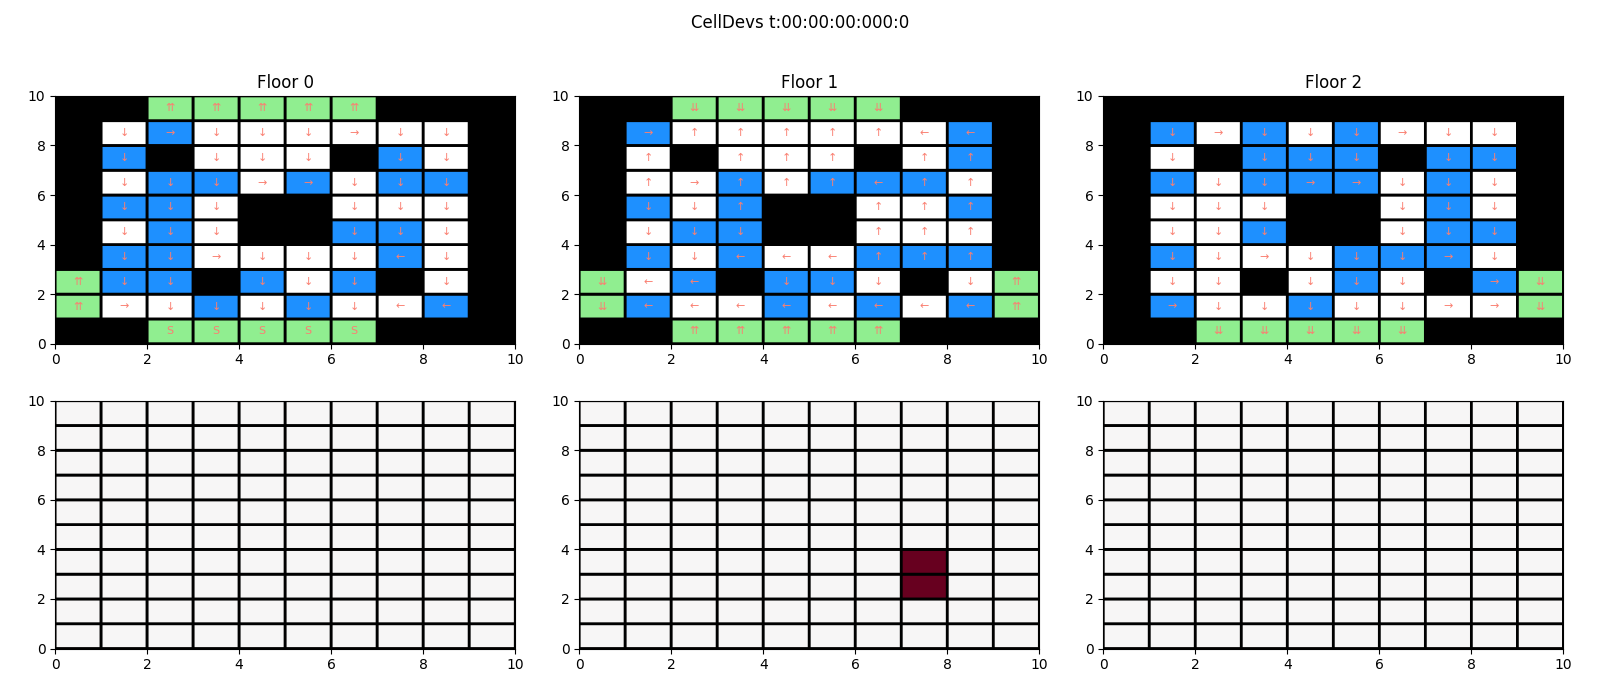

In [186]:
from IPython.display import Image
from IPython.core.display import HTML

PATH = str(CDPP_EXAMPLES_CELL)+'/CellDEVS-EvacuacionEdificio/code/img/'
Image(filename = PATH + "building1-humo-log01-00-00-00-000-0.png", width=2000, height=500)

En las grillas de abajo podemos notar los dos focos de humo en el primer piso y la ausencia de humo en los demás pisos.

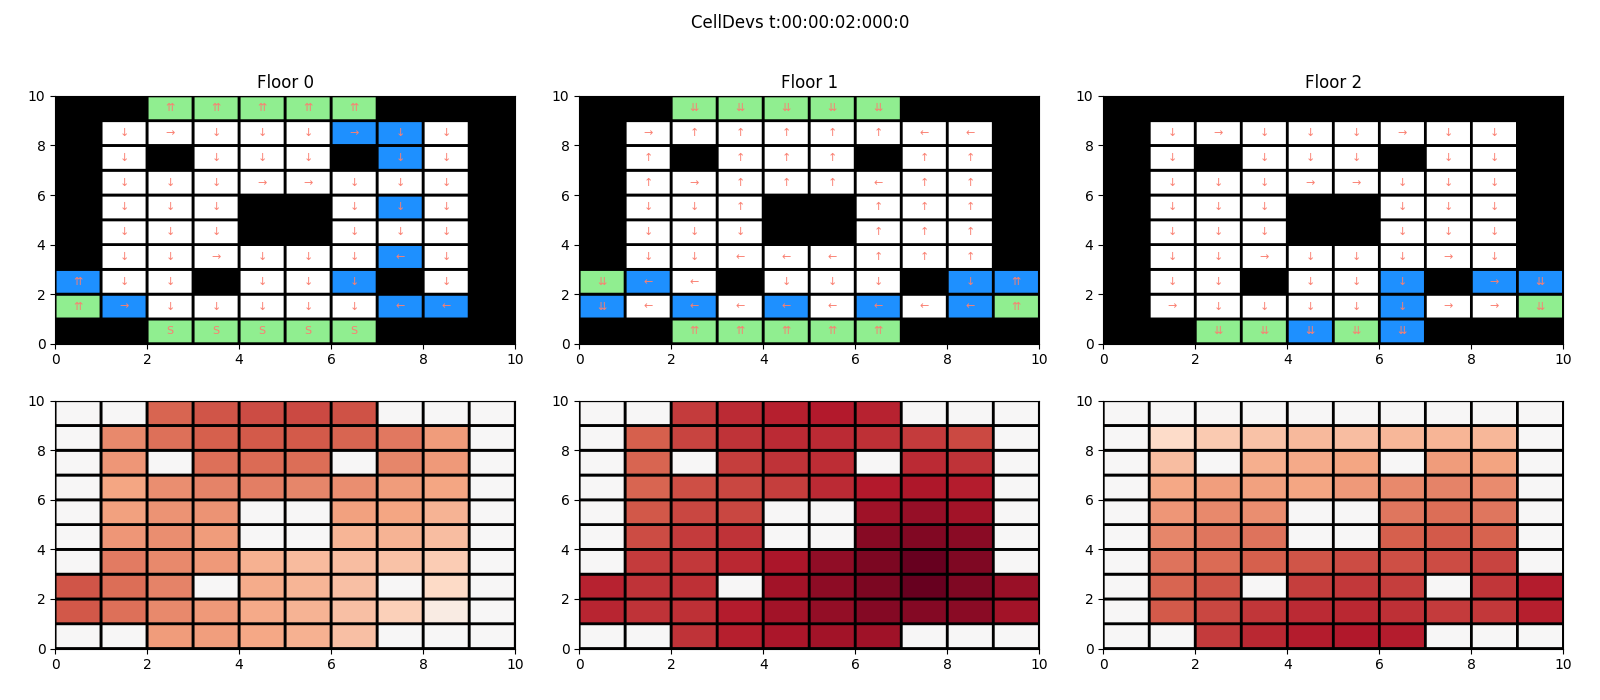

In [187]:
from IPython.display import Image
from IPython.core.display import HTML

PATH = str(CDPP_EXAMPLES_CELL)+'/CellDEVS-EvacuacionEdificio/code/img/'
Image(filename = PATH + "building1-humo-log01-00-00-02-000-0.png", width=2000, height=500)

Aquí podemos notar como en poco tiempo el humo se expandió a los otros pisos al difundirse por los huecos de las escaleras.

Podemos observar también que el humo no se difunde en las celdas que contienen pared.

<a id='con-humo-con-accidentes'></a>
# Ejemplo 3: Evacuación con humo y accidentes

* En este último ejemplo se introduce la interacción entre el humo y las personas. 
  * Consideraremos que al atravesar una celda con humo, las personas tienen una probabilidad de quedarse incapacitadas que depende de la concentración del humo. 
  * Una persona incapacitada no se moverá a los sucesivos tiempos, bloqueando la celda correspondiente.
  * Consideraremos por último que con el avanzar el tiempo hay probabilidad de que una persona caı́da se recupere y vuelva al estado normal en movimiento.


* En esta versión se modifica la codificación de estados del componente de la tupla que maneja el estado de las personas. 
  * Se debe agregar un nuevo estado que manifieste que una celda está ocupada por una persona caı́da.
  * La segunda componente de la tupla describe si no hay persona, si hay y si está incapacitada:

|Valor|Persona|
|:-|:-|
|0| Libre|
|1| <span style='background:lightblue' > Ocupado</span>|
|2| <span style='background:orange'> Ocupada con persona caída</span>|

## Modelo _cell-DEVS_ de la superficie

* El modelo cell-DEVS tiene: 
  * Tamaño: $10 \times 10 \times 6$
  * Bordes: _wrapped_
  * Retardo: _transporte_

### Vecindario

* El vecindario que se utiliza en esta versión es el mismo que el utilizado en la versión con capa de humo visto previamente.

### Valores iniciales

Al igual que en el caso anterior todas las celdas inician con valor $[0,0]$: 
```
initialvalue : [0,0]
```

Además algunas celdas reciben valores particulares y se asignan mediante el archivo `building1_accidentes.val`.

El único cambio con respecto a los valores iniciales del ejemplo anterior es la ubicación de los dos focos de humo en la capa de humo correspondiente al primer piso:

```
(6,6,3) = [0,100000.0]
(7,6,3) = [0,100000.0]
```

A continuación veamos el contenido del archivo de inicialzación:

In [ ]:
%%bash -s "$CDPP_EXAMPLES_CELL"

cd $1/CellDEVS-EvacuaciónEdificio/code/

tail -n3 building1_accidentes.val  

### Reglas

A las reglas del modelo de evacuación con humo se agregan dos reglas de interacción entre las personas y el humo.

* **Regla 1**

  * Si la celda actual está ocupada ($(0,0,0)!1 = 1$) y en la celda hay humo ($(0,0,1)!1$ es distinto de $0$) entonces hay una probabilidad que la persona quede accidentada ($[(0,0,0)!0,2]$).
  
```
   rule : {[(0,0,0)!0,2]} 99 { 0.10*((0,0,1)!1)/100000.0 > uniform(0,1) and (0,0,0)!1 = 1 }
```

* **Regla 2**

  * Si en la celda actual hay una persona accidentada ($(0,0,0)!1 = 2$) entonces con un $50$ % de probabilidad ($uniform(0,1) > 0.5$) esa persona puede recuperarse ($[(0,0,0)!0,1]$).
  
```
   rule : {[(0,0,0)!0,1]} 99 { (0,0,0)!1 = 2 and uniform(0,1) > 0.5 }
```

Con la ayuda de un visualizador de texto podemos ver el contenido del archivo `building1_accidentes.ma`:

In [ ]:
%%bash -s "$CDPP_EXAMPLES_CELL"

cd $1/CellDEVS-EvacuacionEdificio/code/

cat building1_accidentes.ma  

## Simulación del modelo con CD++

Simulemos $2~\text{s}$ de la evacuación:

In [ ]:
%%bash -s "$CDPP_EXAMPLES_CELL"

cd $1/CellDEVS-EvacuacionEdificio/code

# Corre el modelo
../../../../src/bin/cd++ -m building1_accidentes.ma \
                         -l ./logs/building1_accidentes.log \
                         -o ./logs/building1_accidentes.out \
                         -t 00:00:02:000

## Análisis de los resultados

En este caso no podremos utilizar el visualizador Web Viewer ni el Drawlog porque no manejan tuplas.

Utilizamos el mismo visualizadaor `helperDrawHumo` que en el ejemplo anterior.

### Visualización _helperDrawHumo_

Se armo un script para facilitar la visualización de los logs donde es posible detallar que instante de tiempo de la simulación se desea simular.

Ejemplo: 

```
     ./helperDrawHumo.py -x 10 -y 10 -z 3  -out png -plot 1 -adv 1 -time 00:00:00:500:0 -log ./logs/building1_accidentes.log01
```  

donde: 

* `x` :   size x del plano
* `y` :   size y del plano
* `z` :   cantidad de pisos del edificio
* `out`:  png | pdf. Genera un archivo de salida en la carpeta img/
* `plot`: 1 | 0, si queres que salga la pantalla de matplotlib
* `adv`:  1 para simulador avanzado, 0 para parsear logs generados por el sim de la VM
* `time`: El tiempo que querés visualizar
* `log`:  El archivo de log que generó el simulador cd++

Veamos una imagen de los instantes inicial y final de la simulación:

In [188]:
%%bash -s "$CDPP_EXAMPLES_CELL"

cd $1/CellDEVS-EvacuacionEdificio/code

# instante inicial
./helperDrawHumo.py -x 10 -y 10 -z 3 -out png -plot 0 -adv 1 -time 00:00:00:000:0 -log ./logs/building1_accidentes.log01

#instante intermedio
./helperDrawHumo.py -x 10 -y 10 -z 3 -out png -plot 0 -adv 1 -time 00:00:00:500:0 -log ./logs/building1_accidentes.log01

./helperDrawHumo.py -x 10 -y 10 -z 3 -out png -plot 0 -adv 1 -time 00:00:00:600:0 -log ./logs/building1_accidentes.log01

#instante final
./helperDrawHumo.py -x 10 -y 10 -z 3 -out png -plot 0 -adv 1 -time 00:00:02:000:0 -log ./logs/building1_accidentes.log01

El resultado se almacena en la carpeta `img/`:

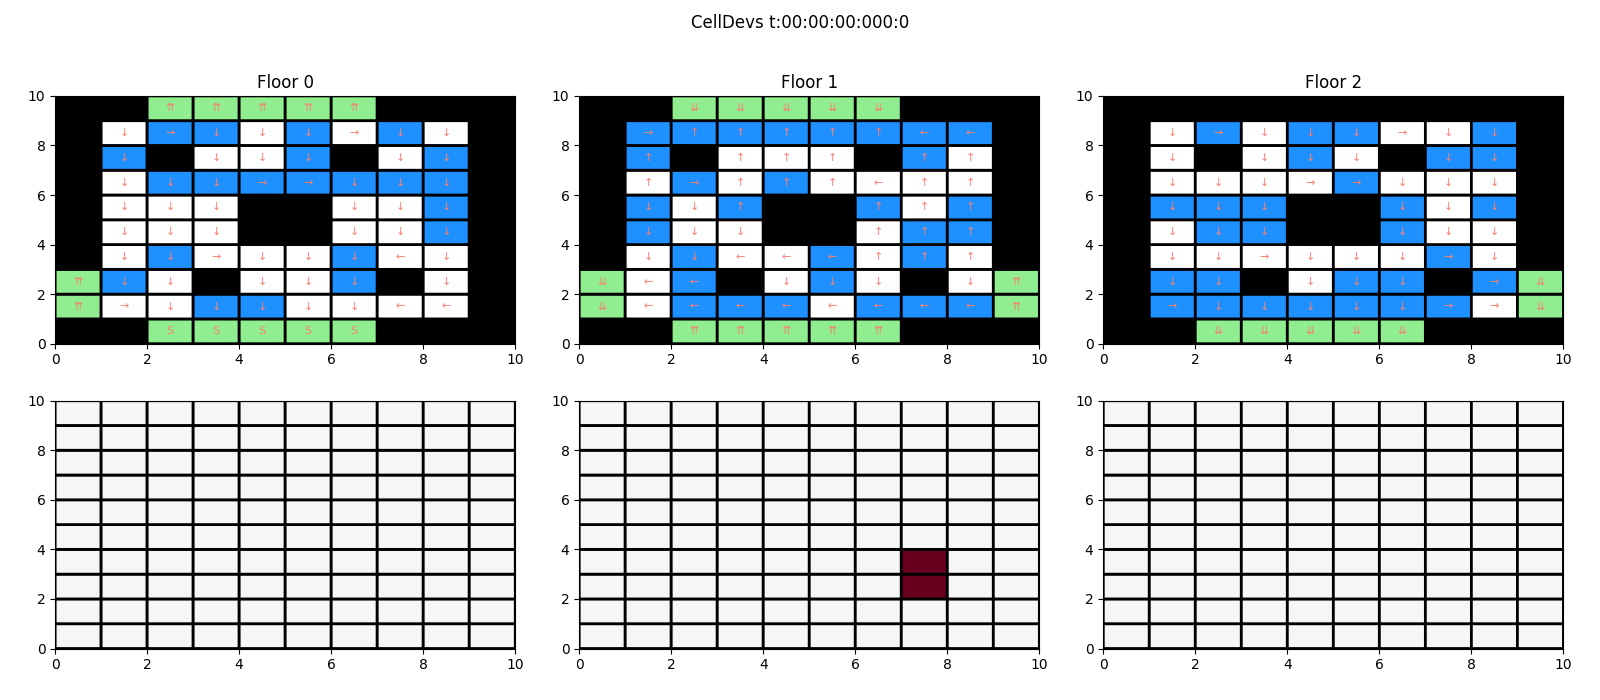

In [189]:
from IPython.display import Image
from IPython.core.display import HTML

PATH = str(CDPP_EXAMPLES_CELL)+'/CellDEVS-EvacuacionEdificio/code/img/'
Image(filename = PATH + "building1-accidentes-log01-00-00-00-000-0.png", width=2000, height=500)

En el instante inicial de la simulación se puede observar la distribución de las personas y el foco inicial de humo. 

Las personas de pie se representan en color azul. 

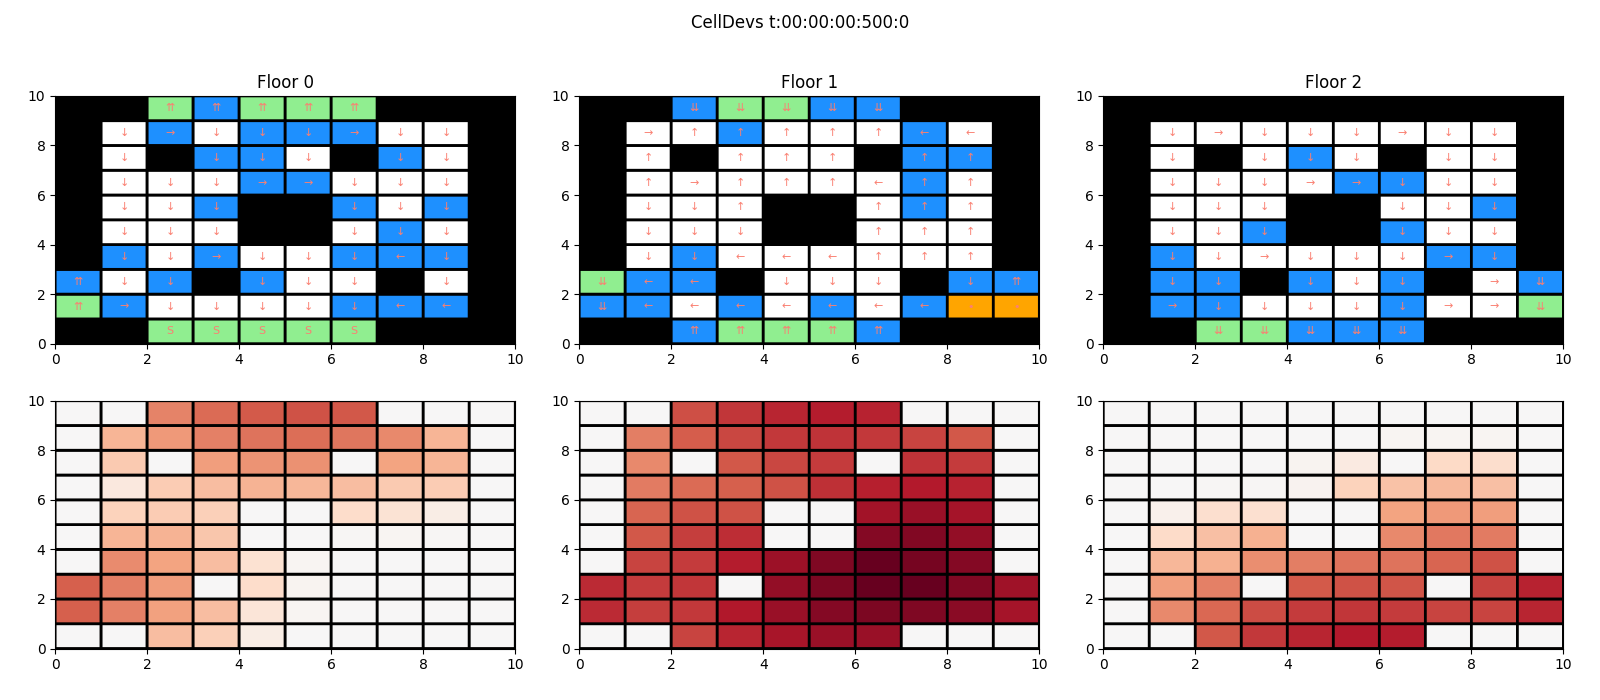

In [190]:
from IPython.display import Image
from IPython.core.display import HTML

PATH = str(CDPP_EXAMPLES_CELL)+'/CellDEVS-EvacuacionEdificio/code/img/'
Image(filename = PATH + "building1-accidentes-log01-00-00-00-500-0.png", width=2000, height=500)

Las personas caı́das se representan en naranja.

Transcurrido un tiempo y por acción del humo, se puede observar que un grupo de personas se han caı́do: una persona accidentada en la escalera que desciende del primer piso a la planta baja y otra a su izquierda.

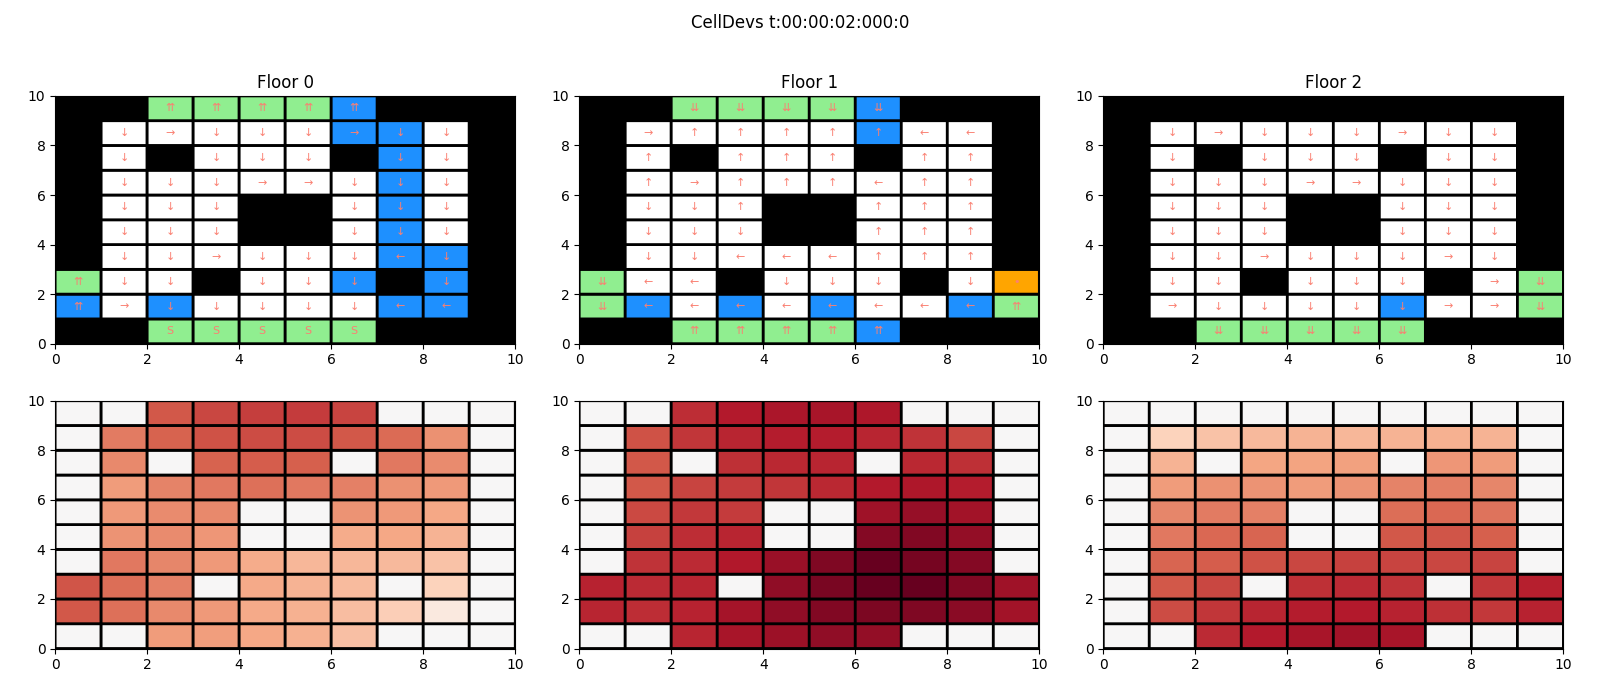

In [191]:
from IPython.display import Image
from IPython.core.display import HTML

PATH = str(CDPP_EXAMPLES_CELL)+'/CellDEVS-EvacuacionEdificio/code/img/'
Image(filename = PATH + "building1-accidentes-log01-00-00-02-000-0.png", width=2000, height=500)

Aleatoriamente, algunas personas lograrán recuperarse y volver al movimiento de evacuación normal, mientras que otras permanecerán caı́das hasta recuperarse.